## import 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os 
import datetime
from sklearn.preprocessing import LabelEncoder

import sklearn
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
import lightgbm as lgb
from tqdm.notebook import tqdm

#한글깨짐방지
plt.rc('font',family='Malgun Gothic')
plt.rcParams['axes.unicode_minus'] = False

In [2]:
print('Pandas : %s'%(pd.__version__))
print('Numpy : %s'%(np.__version__))
print('Scikit-Learn : %s'%(sklearn.__version__))
!python --version

Pandas : 1.0.1
Numpy : 1.18.1
Scikit-Learn : 0.22.1
Python 3.7.6


### data

In [3]:
#데이터로드
path = './data/'
data = pd.read_csv(path +'201901-202003.csv')
submission = pd.read_csv(path + 'submission.csv')

In [4]:
# 시군구 결측은 모두 세종
data.loc[data.CARD_CCG_NM.isna(),'CARD_CCG_NM'] = '세종'
data.loc[data.HOM_CCG_NM.isna(),'HOM_SIDO_NM'] = '세종'

In [5]:
data.shape, submission.shape

((24697792, 12), (1394, 5))

### 전처리

In [6]:
data['year'] = data['REG_YYMM'].apply(lambda x : int(str(x)[:4]))
data['month'] = data['REG_YYMM'].apply(lambda x : int(str(x)[4:]))
data.drop(['REG_YYMM'],axis= 1,inplace = True)

In [7]:
data.shape

(24697792, 13)

In [8]:
#데이터 정제
df = data.copy()
df = df.drop(['CARD_CCG_NM','HOM_CCG_NM'],axis= 1)

columns = ['CARD_SIDO_NM','STD_CLSS_NM', 'HOM_SIDO_NM','AGE','SEX_CTGO_CD',"FLC","year",'month']
grouped = df.groupby(columns).sum().reset_index(drop=False)

In [9]:
#인코딩
dtypes = grouped.dtypes
encoders = {}
for column in grouped.columns:
    if str(dtypes[column]) == 'object':
        encoder = LabelEncoder()
        encoder.fit(grouped[column])
        encoders[column] = encoder
for column in encoders.keys():
    encoder = encoders[column]
    grouped[column] = encoder.transform(grouped[column])

### 외부데이터) 18년 사업체총조사 반영

In [10]:
all_jobs_df = pd.read_csv('./data/외부데이터/18 사업체총조사_키워드매칭.csv',encoding = 'cp949')
all_jobs_df = all_jobs_df[['행정구역별','데이터업종명','사업체수 (개)', '종사자수 (명)']]
all_jobs_df.columns = ['CARD_SIDO_NM','STD_CLSS_NM', 'company','employee']
all_jobs_df.employee = all_jobs_df.employee.apply(lambda x : x.replace("X","0")).astype(int)
all_jobs_df = all_jobs_df.groupby(['CARD_SIDO_NM','STD_CLSS_NM'])[['company','employee']].sum().reset_index()

all_jobs_df = all_jobs_df[~(all_jobs_df.CARD_SIDO_NM == '전국')]

encoder = encoders['CARD_SIDO_NM']
all_jobs_df['CARD_SIDO_NM'] = encoder.transform(all_jobs_df['CARD_SIDO_NM'])

encoder = encoders['STD_CLSS_NM']
all_jobs_df['STD_CLSS_NM'] = encoder.transform(all_jobs_df['STD_CLSS_NM'])

In [11]:
grouped.shape

(1057394, 11)

In [12]:
#없는 업종 row라도 생성 
grouped = pd.merge(grouped,all_jobs_df,on =['CARD_SIDO_NM','STD_CLSS_NM'],how = 'left')

In [13]:
grouped.shape

(1057394, 13)

### Feature Engineering & Initial Modeling
* private은 4월을 예측 (20년 1월까지 데이터로 예측)
* public은 7월을 예측 (20년4월까지 데이터활용)

### Model Tuning & Evaluation

In [14]:
#2019.12까지 데이터로 20.03을 예측
train_set = grouped[grouped.year == 2019]
eval_set = grouped[(grouped.year == 2020)&(grouped.month == 3)]

In [15]:
params = {'random_state': 42,
          'learning_rate': 0.01,
          'max_depth': 8,
          'num_leaves': 64,
          'boosting': 'gbdt',
          'objective': 'regression',
          'metric': 'rmse',
          'feature_fraction': 0.9,
          'bagging_fraction': 0.7}

In [16]:
#eval, train 구성
train_x = train_set.drop(['CSTMR_CNT','AMT','CNT'],axis= 1)
train_y = np.log1p(train_set['AMT'])

eval_x = eval_set.drop(['CSTMR_CNT','AMT','CNT'],axis= 1)
eval_y = np.log1p(eval_set['AMT'])

train_ds = lgb.Dataset(train_x,label=train_y,free_raw_data=False,
                       categorical_feature=['CARD_SIDO_NM','STD_CLSS_NM','HOM_SIDO_NM','SEX_CTGO_CD','AGE','FLC'])
eval_ds = lgb.Dataset(eval_x,label=eval_y,free_raw_data=False,
                      categorical_feature=['CARD_SIDO_NM','STD_CLSS_NM','HOM_SIDO_NM','SEX_CTGO_CD','AGE','FLC'])

In [17]:
evaluation_results ={}
model = lgb.train(params,train_ds,
                  num_boost_round=10000,
                  valid_sets=[train_ds, eval_ds],
                  valid_names=['Train', 'Eval'],
                  verbose_eval=500,
                  early_stopping_rounds=100, evals_result = evaluation_results)

C:\Users\kwonJH\anaconda3\lib\site-packages\lightgbm\basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 100 rounds
[500]	Train's rmse: 1.62022	Eval's rmse: 1.73656
[1000]	Train's rmse: 1.2644	Eval's rmse: 1.44944
[1500]	Train's rmse: 1.12303	Eval's rmse: 1.34153
[2000]	Train's rmse: 1.01707	Eval's rmse: 1.26973
[2500]	Train's rmse: 0.937464	Eval's rmse: 1.22345
[3000]	Train's rmse: 0.884403	Eval's rmse: 1.19493
[3500]	Train's rmse: 0.843358	Eval's rmse: 1.17588
[4000]	Train's rmse: 0.810411	Eval's rmse: 1.16188
[4500]	Train's rmse: 0.78564	Eval's rmse: 1.15365
[5000]	Train's rmse: 0.766183	Eval's rmse: 1.14725
[5500]	Train's rmse: 0.750489	Eval's rmse: 1.14218
[6000]	Train's rmse: 0.736961	Eval's rmse: 1.13931
Early stopping, best iteration is:
[5982]	Train's rmse: 0.737356	Eval's rmse: 1.13889


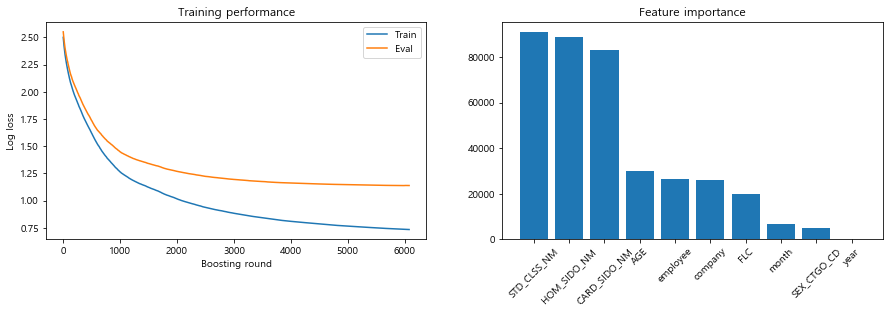

In [18]:
fig, axs = plt.subplots(1, 2, figsize=[15, 4])

# Plot the log loss during training
axs[0].plot(evaluation_results['Train']['rmse'], label='Train')
axs[0].plot(evaluation_results['Eval']['rmse'], label='Eval')
axs[0].set_ylabel('Log loss')
axs[0].set_xlabel('Boosting round')
axs[0].set_title('Training performance')
axs[0].legend()

# Plot feature importance
importances = pd.DataFrame({'features': model.feature_name(), 
                            'importance': model.feature_importance()}).sort_values('importance', ascending=False)
axs[1].bar(x=np.arange(len(importances)), height=importances['importance'])
axs[1].set_xticks(np.arange(len(importances)))
axs[1].set_xticklabels(importances['features'],rotation=45)
axs[1].set_title('Feature importance')

plt.show()

In [19]:
#예측 탬플릿 만들기
CARD_SIDO_NMs = grouped['CARD_SIDO_NM'].unique()
STD_CLSS_NMs = grouped['STD_CLSS_NM'].unique()
HOM_SIDO_NMs = grouped['HOM_SIDO_NM'].unique()
AGEs = grouped['AGE'].unique()
SEX_CTGO_CDs = grouped['SEX_CTGO_CD'].unique()
FLCs = grouped['FLC'].unique()
years = [2020]
months = [3]

temp = []
for CARD_SIDO_NM in tqdm(CARD_SIDO_NMs):
    for STD_CLSS_NM in STD_CLSS_NMs:
        for HOM_SIDO_NM in HOM_SIDO_NMs:
            for AGE in AGEs:
                for SEX_CTGO_CD in SEX_CTGO_CDs:
                    for FLC in FLCs:
                        for year in years:
                            for month in months:
                                temp.append([CARD_SIDO_NM, STD_CLSS_NM, HOM_SIDO_NM, AGE, SEX_CTGO_CD, FLC, year, month])
temp = np.array(temp)
temp = pd.DataFrame(data=temp, columns = train_x.columns[:-2])

In [20]:
temp = pd.merge(temp,all_jobs_df,on =['CARD_SIDO_NM','STD_CLSS_NM'],how = 'outer')

In [21]:
# 예측
pred = model.predict(temp)
pred = np.expm1(pred)
temp['AMT'] = np.round(pred,0)
temp['REG_YYMM'] = temp['year']*100 +temp['month']
temp = temp[['REG_YYMM','CARD_SIDO_NM','STD_CLSS_NM','AMT']]
temp = temp.groupby(['REG_YYMM','CARD_SIDO_NM','STD_CLSS_NM']).sum().reset_index(drop=False)

In [22]:
temp['CARD_SIDO_NM'] = temp['CARD_SIDO_NM'].astype(int)
temp['STD_CLSS_NM'] = temp['STD_CLSS_NM'].astype(int)

In [23]:
# 디코딩
temp['CARD_SIDO_NM'] = encoders['CARD_SIDO_NM'].inverse_transform(temp['CARD_SIDO_NM'])
temp['STD_CLSS_NM'] = encoders['STD_CLSS_NM'].inverse_transform(temp['STD_CLSS_NM'])

In [24]:
#정답
eval_set['REG_YYMM'] = eval_set['year']*100 +eval_set['month']
eval_set = eval_set[['REG_YYMM','CARD_SIDO_NM','STD_CLSS_NM','AMT']]
eval_set_answer = eval_set.groupby(['REG_YYMM','CARD_SIDO_NM','STD_CLSS_NM']).sum().reset_index(drop=False)

C:\Users\kwonJH\anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [25]:
# 디코딩
eval_set_answer['CARD_SIDO_NM'] = encoders['CARD_SIDO_NM'].inverse_transform(eval_set_answer['CARD_SIDO_NM'])
eval_set_answer['STD_CLSS_NM'] = encoders['STD_CLSS_NM'].inverse_transform(eval_set_answer['STD_CLSS_NM'])

In [26]:
eval_set_answer.columns = ['REG_YYMM', 'CARD_SIDO_NM', 'STD_CLSS_NM', 'AMT_answer']

In [27]:
temp = pd.merge(temp,eval_set_answer,how = 'left')

In [28]:
#강원 정기 항공 운송업,면세점은 데이터로 보유하고 있지 않음. 근데 높게 예측 
temp.loc[temp.AMT_answer.isna()]
# temp.loc[temp.AMT_answer.isna()].to_csv('./insight/없는없종na로라도 넣어봄.csv')

,REG_YYMM,CARD_SIDO_NM,STD_CLSS_NM,AMT,AMT_answer
4,202003,강원,그외 기타 분류안된 오락관련 서비스업,15802890.0,NaN
14,202003,강원,면세점,131424528.0,NaN
15,202003,강원,버스 운송업,20169544.0,NaN
30,202003,강원,정기 항공 운송업,310128380.0,NaN
35,202003,강원,택시 운송업,6157102.0,NaN
...,...,...,...,...,...
670,202003,충북,면세점,93073440.0,NaN
671,202003,충북,버스 운송업,10857886.0,NaN
679,202003,충북,여행사업,19047558.0,NaN
684,202003,충북,자동차 임대업,32956585.0,NaN


### predict

In [29]:
#train to private
one = grouped[grouped.year == 2019]
two = grouped[(grouped.year == 2020)&(grouped.month == 1)]

p_train = pd.concat([one,two])

In [30]:
# Feature, taget 설정
train_features = p_train.drop(['CSTMR_CNT','AMT','CNT'],axis= 1)
train_target = np.log1p(p_train['AMT'])

In [31]:
train_ds = lgb.Dataset(train_features,label=train_target)
model = lgb.train(params,train_ds,num_boost_round=1000)

In [32]:
#예측 탬플릿 만들기
CARD_SIDO_NMs = grouped['CARD_SIDO_NM'].unique()
STD_CLSS_NMs = grouped['STD_CLSS_NM'].unique()
HOM_SIDO_NMs = grouped['HOM_SIDO_NM'].unique()
AGEs = grouped['AGE'].unique()
SEX_CTGO_CDs = grouped['SEX_CTGO_CD'].unique()
FLCs = grouped['FLC'].unique()
years = [2020]
months = [4, 7]

temp = []
for CARD_SIDO_NM in tqdm(CARD_SIDO_NMs):
    for STD_CLSS_NM in STD_CLSS_NMs:
        for HOM_SIDO_NM in HOM_SIDO_NMs:
            for AGE in AGEs:
                for SEX_CTGO_CD in SEX_CTGO_CDs:
                    for FLC in FLCs:
                        for year in years:
                            for month in months:
                                temp.append([CARD_SIDO_NM, STD_CLSS_NM, HOM_SIDO_NM, AGE, SEX_CTGO_CD, FLC, year, month])
temp = np.array(temp)
temp = pd.DataFrame(data=temp, columns = train_features.columns[:-2])

In [33]:
temp = pd.merge(temp,all_jobs_df,on =['CARD_SIDO_NM','STD_CLSS_NM'],how = 'left')

In [34]:
# 예측
pred = model.predict(temp)
pred = np.expm1(pred)
temp['AMT'] = np.round(pred,0)
temp['REG_YYMM'] = temp['year']*100 +temp['month']
temp = temp[['REG_YYMM','CARD_SIDO_NM','STD_CLSS_NM','AMT']]
temp = temp.groupby(['REG_YYMM','CARD_SIDO_NM','STD_CLSS_NM']).sum().reset_index(drop=False)

In [35]:
# 디코딩
temp['CARD_SIDO_NM'] = encoders['CARD_SIDO_NM'].inverse_transform(temp['CARD_SIDO_NM'])
temp['STD_CLSS_NM'] = encoders['STD_CLSS_NM'].inverse_transform(temp['STD_CLSS_NM'])

In [36]:
#제출파일
submission = pd.read_csv('data/submission.csv',index_col=0)
submission = submission.drop(['AMT'],axis= 1)
submission = submission.merge(temp, left_on=['REG_YYMM','CARD_SIDO_NM','STD_CLSS_NM'],right_on =['REG_YYMM','CARD_SIDO_NM','STD_CLSS_NM'],how = 'left')
submission.index.name = 'id'

### 해당사업이 없는경우 0 처리

In [37]:
all_jobs_df = pd.read_csv('./data/외부데이터/18 사업체총조사_키워드매칭.csv',encoding = 'cp949')
all_jobs_df = all_jobs_df[['행정구역별','데이터업종명','사업체수 (개)', '종사자수 (명)']]
all_jobs_df.columns = ['CARD_SIDO_NM','STD_CLSS_NM', 'company','employee']
all_jobs_df.employee = all_jobs_df.employee.apply(lambda x : x.replace("X","0")).astype(int)
all_jobs_df = all_jobs_df.groupby(['CARD_SIDO_NM','STD_CLSS_NM'])[['company','employee']].sum().reset_index()

#제출파일과 비교
check_df = pd.merge(submission,all_jobs_df,left_on=['CARD_SIDO_NM','STD_CLSS_NM'],right_on=['CARD_SIDO_NM','STD_CLSS_NM'],how='left')

In [38]:
check_df.loc[check_df.company.isna(),"AMT"] = 0
check_df.drop(['company','employee'],axis= 1,inplace= True)
submission = check_df

In [39]:
submission.index.name = 'id'
today = datetime.datetime.now().date()
submission.to_csv(f'./submission/{today}_submission_lgbm_test_left.csv', encoding='utf-8-sig')

submission.head()

,REG_YYMM,CARD_SIDO_NM,STD_CLSS_NM,AMT
id,,,,
0,202004,강원,건강보조식품 소매업,3.459976e+08
1,202004,강원,골프장 운영업,1.562328e+09
2,202004,강원,과실 및 채소 소매업,8.243249e+08
3,202004,강원,관광 민예품 및 선물용품 소매업,1.099997e+08
4,202004,강원,그외 기타 분류안된 오락관련 서비스업,1.078292e+08


In [40]:
submission.shape

(1394, 4)